# Keras and Tensorflow implementation of SGAN on MNIST data set

## Goals:
1. Semi-supervised training using Wasserstein GANs
2. Network visualization with tensorboard
3. Training visualisation with tensorboard
4. 3D embedding visualisation
5. Port final solution to Traffic sign classification task with RGB images

In [1]:
#Import all libraries and MNIST dataset

#Package specifications
#Tensorflow-gpu: tensorflow=1.0.0
#Keras: keras=2.0.2

import keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.datasets import mnist
import pandas as pd

img_rows, img_cols = 28, 28
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


![Basic GAN architecture](generative-adversarial-network.png)

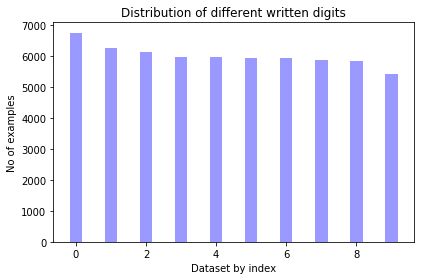

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#Data cleaning and dataset visualization

#Make data consumable with Keras
#Train data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], -1).astype('float32')
Y_train = y_train.reshape(y_train.shape[0], -1).astype('float32')
#Test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], -1).astype('float32')
Y_test = y_test.reshape(y_test.shape[0], -1).astype('float32')

#Normalize all data [0, 1] with mean zero
X_train/=255
X_test/=255

#Plot distribution of data set
def barchart(y_data, title, x_axis_label, y_axis_label):
    d_count = pd.Series(y_data).value_counts().tolist()
    n_groups = len(d_count)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    plt.bar(index, d_count, bar_width,
                     alpha=opacity,
                     color='b')
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

barchart(y_train, 'Distribution of different written digits', 'Dataset by index', 'No of examples')

In [3]:
#Build the generative and adversarial models
#Model advice taken from https://github.com/soumith/ganhacks

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Lambda, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.layers import Merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers import ZeroPadding2D, Deconvolution2D
from keras.callbacks import TensorBoard
import tensorflow as tf

def Generator(LatentVector):
    #Use GPU
    with tf.device('/gpu:0'):
        #Size of latent matrix
        latent_vector_size = LatentVector

        width =  14  # Hand picked width of the 'meta' image 
        filters = 100 # No of the kernels in convolution

        latent_vector_input = Input(shape=[latent_vector_size])
        G = Dense(width*width*filters, kernel_initializer='glorot_normal')(latent_vector_input)
        G = Dropout(0.5)(G)
        
        G = BatchNormalization(axis=-1)(G)
        G = LeakyReLU(0.2)(G)

        G = Reshape([width, width, filters])(G)
        G = UpSampling2D(size=(2, 2))(G)
        G = Conv2D(filters = filters//2, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_uniform')(G)
        G = Dropout(0.5)(G)
            
        G = BatchNormalization(axis=-1)(G)
        G = LeakyReLU(.2)(G)

        G = Conv2D(filters=width//4, kernel_size=(3, 3), padding='same')(G)
        G = Dropout(0.5)(G)
        G = BatchNormalization(axis=-1)(G)
        G = LeakyReLU(.2)(G)
        G = Conv2D(filters = 1, kernel_size=(1, 1), padding='same')(G)
        generated_image = Activation('tanh')(G)

        #Final model
        model = Model(inputs=latent_vector_input, outputs=generated_image)
        model.compile(loss='binary_crossentropy', optimizer="ADAM")
        return model

def Discriminator(ImageShape):
    #Use GPU
    with tf.device('/gpu:0'):
        InputImage = Input(ImageShape)
        D = Conv2D(filters=16, kernel_size=(5, 5), padding= 'same')(InputImage)
        D = LeakyReLU(.2)(D)
        D = AveragePooling2D(pool_size=(2, 2))(D)
        D = Conv2D(filters=32,  kernel_size=(5, 5), padding = 'same')(D)
        D = AveragePooling2D(pool_size=(2, 2))(D)
        D = Flatten()(D)
        D = Dense(256)(D)
        D = LeakyReLU(.2)(D)
        D = Dense(1)(D)
        D = Activation('sigmoid')(D)

        #Final model
        model = Model(inputs=InputImage, outputs=D)

        return model

def GeneratorWithDiscriminator(Generator, Discriminator):
    #Freeze weights in Descriminator as part of minimax game
    #Use GPU
    with tf.device('/gpu:0'):
        Discriminator.trainable = False

        #Create Generator Trainer
        model = Sequential()
        model.add(Generator)
        model.add(Discriminator)

        return model  

#Test models   
Generator(LatentVector=100).summary()
Discriminator((28, 28, 1)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 19600)             1979600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 19600)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 19600)             78400     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 19600)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 100)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 100)       0         
__________

In [4]:
#Generate image sprites to show training
import math
def SpriteGen(image_batches):
    #Convert to 8 bit matrix between 0 & 255
    image_batches = (image_batches*127.5+127.5).astype(np.uint8)
    
    number_of_images = image_batches.shape[0]
    
    #Height and width of final sprite image:
    height = int(math.sqrt(number_of_images))
    width = int(math.ceil(number_of_images/height))
    
    image_dim = image_batches.shape[1:]
    
    #Final output sprite image:s
    sprite = np.zeros((height*image_dim[0], width*image_dim[1]))

    for index, img in enumerate(image_batches):
        i = int(index/width)
        j = index % width
        sprite[i*image_dim[0]:(i+1)* image_dim[0], j*image_dim[1]:(j+1)*image_dim[1]] = \
            image_batches[index, :, :].reshape(image_dim[0], image_dim[1])
   
    return sprite       

In [5]:
#Training models and training function
from sklearn.utils import shuffle
from PIL import Image
import scipy.stats as stats
#Create callback for graph visualizations with tensorboard
#GAN_callback = keras.callbacks.TensorBoard(log_dir='../Graph/GAN_graph', histogram_freq=1,  
#          write_graph=True, write_images=True)


def Train(BatchSize, Epochs, LatentVectorSize, DataSet):
    #Use GPU
    with tf.device('/gpu:0'):
        #Set up discriminator
        discriminator = Discriminator(ImageShape=(28, 28, 1))
        discriminator.compile(loss='binary_crossentropy', optimizer="SGD")
        discriminator.trainable = True

        #Set up generator
        generator = Generator(LatentVector=LatentVectorSize)
        #generator = Generator.compile(loss='binary_crossentropy', optimizer="SGD")

        #Set up GAN
        GAN = GeneratorWithDiscriminator(Generator=generator, Discriminator=discriminator)
        GAN.compile(loss='binary_crossentropy', optimizer="ADAM")

        #Get Data
        X_train, Y_train, X_test, Y_test = DataSet

         #Get training data and shuffle
        X_train, Y_train = shuffle(X_train, Y_train)

        for Epoch in range(Epochs):
        #Training sequence: -> Generator -> Descriminator -> GAN
            print('Epoch: {}'.format(Epoch))

            for offset in range(0,X_train.shape[0], BatchSize):
                end = offset + BatchSize
                batch_X_train, batch_Y_train = X_train[offset:end], Y_train[offset:end]
                
                #Use spherical noise between (-1, 1), i.e. Gaussian distribution not uniform noise
                mu, sigma = 0, 1
                lower, upper = -1, 1
                
                #Add to noise batch
                noise_batch = np.asarray([stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,\
                                           loc=mu,scale=sigma,size=LatentVectorSize)\
                                    for i in range(BatchSize)])
                
                #Generate images from Generator
                GeneratedImages =  np.asarray(generator.predict(noise_batch, verbose=1))

                #Save every image every 50 batches and 10 epochs
                if offset%50==0 and Epoch%10==0:
                    SpriteImg = SpriteGen(GeneratedImages)
                    Image.fromarray(SpriteImg, mode='RGB').save("TrainingImages/Epoch_"+str(Epoch)+"_"+\
                                                   "Batch_"+str(offset)+".png")
                #Generate GAN training data
                combined_X_train =  np.vstack((batch_X_train, GeneratedImages))
                
                #If real data set values 0.7 and 1.2, and 0.0 for fake data: i.e. use soft labels
                combined_Y_train = np.hstack((np.random.uniform(0.7, 1.2, BatchSize), \
                                              np.asarray([0.0]*BatchSize)))

                #Discriminator
                d_loss = discriminator.train_on_batch(combined_X_train, combined_Y_train)

                #Train on GAN
                discriminator.trainable = False
                
                #Train GAN 3 times more than discriminator
                for i in range(1, 3):
                    g_loss = GAN.train_on_batch(noise_batch, np.ones(BatchSize))
                discriminator.trainable = True
                
                #Save weights every 10 batches
                if  Epoch%2 == 0:
                    generator.save('Generator.h5')
                    discriminator.save('Discriminator.h5')

            print("Batch: {}, Discriminator Loss: {}".format(offset, d_loss))
            print("Batch: {}, Generator Loss: {}".format(offset, g_loss))  
         

In [10]:
#Set training parameters
Train(BatchSize=200, Epochs=15, LatentVectorSize=100, DataSet=(X_train, Y_train, X_test, Y_test))

Epoch: 0
160/200 [=======================>......] - ETA: 0sWARNING:tensorflow:Tried to colocate gradients_5/batch_normalization_12/moments/sufficient_statistics/count_grad/Rank with an op batch_normalization_12/moments/sufficient_statistics/count that had a different device: /device:CPU:0 vs /device:GPU:0. Ignoring colocation property.


160/200 [=======================>......] - ETA: 0sBatch: 59800, Discriminator Loss: 0.7073172330856323
Batch: 59800, Generator Loss: 0.6588233113288879
Epoch: 1
160/200 [=======================>......] - ETA: 0sBatch: 59800, Discriminator Loss: 0.6961828470230103
Batch: 59800, Generator Loss: 0.733279824256897
Epoch: 2
160/200 [=======================>......] - ETA: 0sBatch: 59800, Discriminator Loss: 0.6963826417922974
Batch: 59800, Generator Loss: 0.7469830513000488
Epoch: 3
160/200 [=======================>......] - ETA: 0sBatch: 59800, Discriminator Loss: 0.6928062438964844
Batch: 59800, Generator Loss: 0.7441248893737793
Epoch: 4
192/200 [===========================>..] - ETA: 0sBatch: 59800, Discriminator Loss: 0.6922749876976013
Batch: 59800, Generator Loss: 0.7451780438423157
Epoch: 5
160/200 [=======================>......] - ETA: 0sBatch: 59800, Discriminator Loss: 0.6915755271911621
Batch: 59800, Generator Loss: 0.7475330233573914
Epoch: 6
192/200 [==========================

KeyboardInterrupt: 

In [11]:
#Generate images from generator
from PIL import Image
from keras.models import load_model

def GenImages(latent_vector):
    generator = load_model('Generator.h5')
    return generator.predict(latent_vector)

noise =  np.zeros((16, 100))
for i in range(16):
    noise[i, :] = np.random.uniform(-1, 1, 100)
    
TestOut = GenImages(noise)

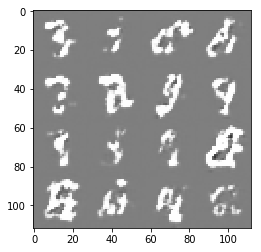

In [12]:
#Generator images
Test = SpriteGen(TestOut)
Timage = Image.fromarray(Test)
plt.imshow(Timage, cmap ='gray')
plt.show()